# About

Training of the BDT to define if track comes from the same side or opposite side.

Labels:
   * 0 (NAN), cannot establish SS or OS
   * -1 (OS) - opposite side tracks (good agreement with indeed OS tracks)
   * 1 (SS) - tracks grandmother, grand-grandmother, grand-grand-grandmother of which is the same as for signal B
   
From test we come up with the statement that SS, NAN should have inverted tracks sing for $K_s$ and $K*$ decays. Thus we train OS vs SS, NAN

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Import

In [2]:
import pandas
import root_numpy
from folding_group import FoldingGroupClassifier
from decisiontrain import DecisionTrainClassifier
from rep.estimators import SklearnClassifier

# Read $B^\pm \to J\psi K^\pm$ MC samples

In [3]:
data = pandas.DataFrame(root_numpy.root2array('datasets/MC/csv/Bu_JPsiK/Tracks.root'))
data = data.ix[numpy.isfinite(data.IPs), :]

In [4]:
selection = " ((PIDNNk > 0) | (PIDNNm > 0) | (PIDNNe > 0) | (PIDNNpi > 0) | (PIDNNp > 0)) & (ghostProb < 0.4)"
data = data.query(selection)

In [5]:
for group in range(-1, 1, 1):
    print group, 1. * numpy.sum(data.OS_SS.values == group) / len(data)

-1 0.0846154165022
0 0.904321385024


In [6]:
len(data)

32808324

In [7]:
features = ['Bmass', 'partP', 'partPt', 'ptB', 'IPs', 'IP', 'IPerr', 
            'partlcs', 'EOverP', 'ghostProb', 'IPPU', 'nnkrec', 
            'PIDNNk', 'PIDNNpi', 'PIDNNp', 'PIDNNm', 'PIDNNe',
            'diff_eta', 'diff_phi', 'phi', 'eta', 'proj', 'veloch',
            'Dist_phi']

## distributions for same side vs opposide side tracks

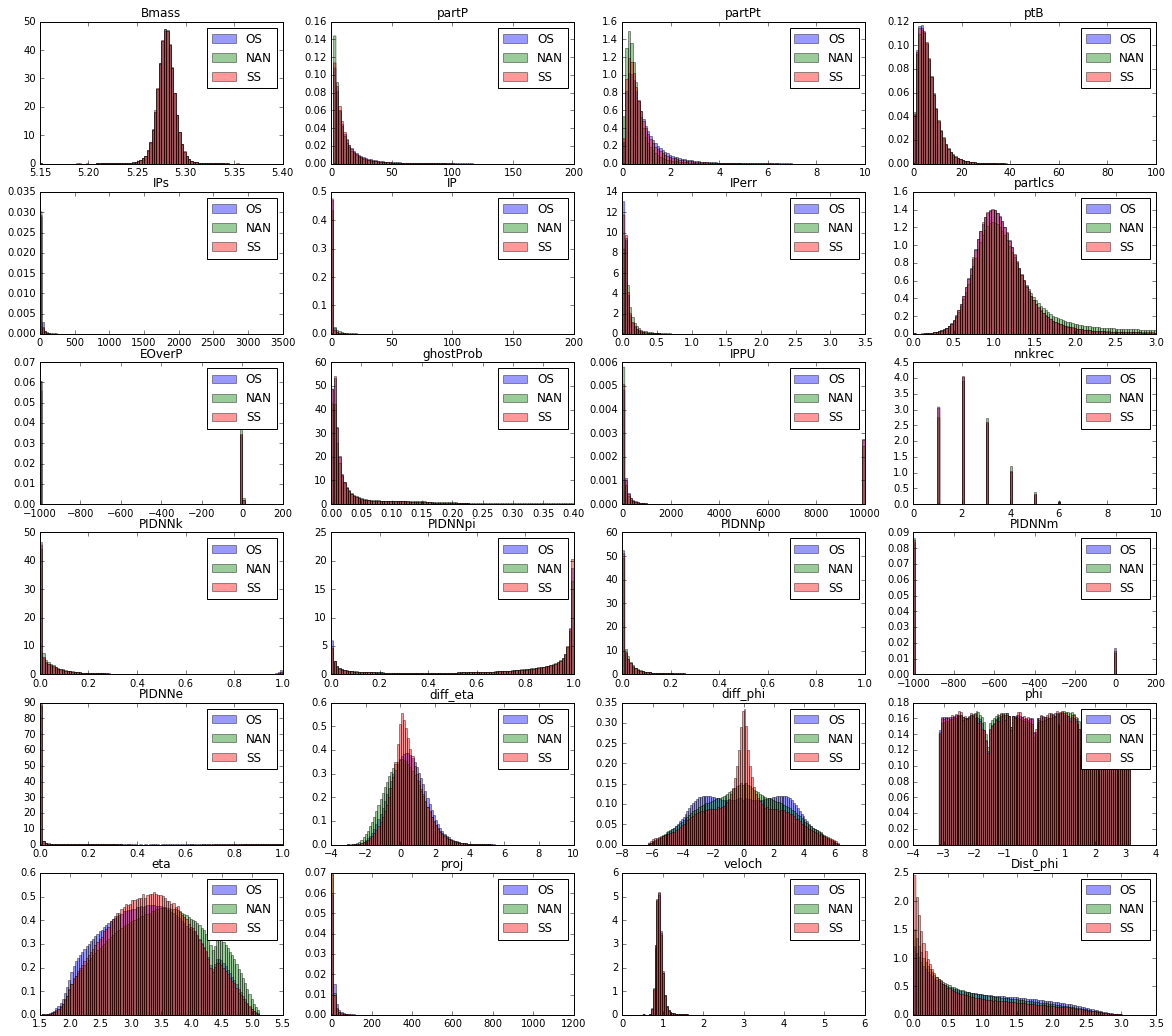

In [8]:
kw = {'bins': 100, 'alpha': 0.4, 'normed': True}
figure(figsize=(20, 30))
for n, f in enumerate(features):
    subplot(10, 4, n + 1)
    r = (numpy.min(data.loc[data.OS_SS == -1, f].values), numpy.max(data.loc[data.OS_SS == -1, f].values))
    hist(data.loc[data.OS_SS == -1, f].values, label='OS', range=r, **kw)
    hist(data.loc[data.OS_SS == 0, f].values, label='NAN', range=r, **kw)
    hist(data.loc[data.OS_SS == 1, f].values, label='SS', range=r, **kw)
    title(f)
    legend()

In [9]:
data['event_id'] = data.run.apply(str) + '_' + data.event.apply(str)
data['group_column'] = numpy.unique(data['event_id'], return_inverse=True)[1]

# Training OS vs SS

In [ ]:
data_os_ss = data
weight = numpy.ones(len(data_os_ss))
weight[data_os_ss.OS_SS.values >= 0] *= 1. * sum(data_os_ss.OS_SS < 0) / sum(data_os_ss.OS_SS >= 0)
data_os_ss['weight'] = weight

In [ ]:
tt_base = DecisionTrainClassifier(learning_rate=0.1, n_estimators=10000, depth=6,
                                  max_features=15, n_threads=12)
tt_folding = FoldingGroupClassifier(SklearnClassifier(tt_base), n_folds=2, random_state=532, 
                                    train_features=features, group_feature='group_column')
%time tt_folding.fit(data_os_ss, data_os_ss.OS_SS >= 0)
pass

In [12]:
import cPickle 
with open('models/dt_ss_os.pkl', 'w') as f:
    cPickle.dump(tt_folding, f)

In [13]:
prob = tt_folding.predict_proba(data_os_ss)[:, 1]

KFold prediction using folds column


In [14]:
from sklearn.metrics import roc_auc_score
roc_auc_score(data_os_ss.OS_SS >= 0, prob, sample_weight=data_os_ss.weight)

0.86734673577445431

# Calibration to probability to be SS

In [15]:
from utils import plot_calibration

### before calibration

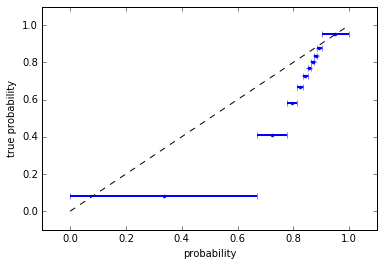

In [16]:
plot_calibration(prob, data_os_ss.OS_SS.values >= 0, weight=data_os_ss.weight.values)

### after calibration

In [17]:
from utils import calibrate_probs

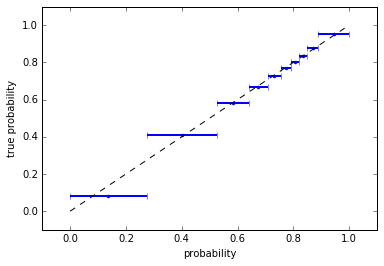

In [18]:
prob_calib, calibrator = calibrate_probs(data_os_ss.OS_SS.values >= 0, data_os_ss.weight.values, prob,
                                         logistic=True)
plot_calibration(prob_calib, data_os_ss.OS_SS.values >= 0, weight=data_os_ss.weight.values)

In [19]:
with open('models/os_ss_calibrator.pkl', 'w') as f:
    cPickle.dump(calibrator, f)

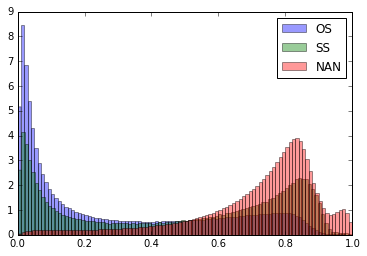

In [20]:
hist(prob_calib[data_os_ss.OS_SS.values < 0], normed=True, alpha=0.4, label='OS', bins=100);
hist(prob_calib[data_os_ss.OS_SS.values > 0], normed=True, alpha=0.4, label='SS', bins=100);
hist(prob_calib[data_os_ss.OS_SS.values == 0], normed=True, alpha=0.4, label='NAN', bins=100);
legend();